In [1]:
import pandas as pd
from dataclasses import asdict
from backdoors import data, patterns, poison, utils, checkpoint_dir
from backdoors.data import load_cifar10, Data
import numpy as np
import matplotlib.pyplot as plt
import einops
import jax
from jax import numpy as jnp
from flax.training import train_state
import optax
import chex
import flax
from flax import linen as nn
from typing import Tuple
import matplotlib.pyplot as plt
import sympy
from jax import random
from collections import namedtuple
from time import time
rng = random.PRNGKey(0)

import orbax.checkpoint
import os
from pathlib import Path

from backdoors import module_path, checkpoint_dir, train
from backdoors.train import TrainState, Metrics, model, tx, \
    accuracy, train_step, init_train_state
from backdoors.models import CNN
from meta_transformer.data import load_pair_of_models, data_iterator
from tqdm import tqdm


checkpointer = orbax.checkpoint.PyTreeCheckpointer()

BATCH_SIZE = 64
NUM_EPOCHS = 5

#train_data, _ = load_cifar10()
cifar10_train, cifar10_test = load_cifar10()

/home/lauro/.virtualenvs/meta-models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [3]:
def make_optional(fn):
    def wrapped(*args, no_effect: bool = False, **kwargs):
        return jax.lax.cond(no_effect, lambda x: x, fn, *args, **kwargs)
    return wrapped

In [4]:
#batch_size = 64
#num_batches = 200
#thresholds = np.arange(1, batch_size+1) / batch_size
#thresholds = np.tile(thresholds, num_batches)
#
#
#freqs = jnp.linspace(-1.8, -0.8, len(thresholds))
#freqs = 10 ** freqs
#
#to_poison = freqs > thresholds


to_poison = utils.get_indices_to_poison()
subkey, rng = random.split(rng)
to_poison = utils.shuffle_locally(subkey, to_poison, BATCH_SIZE)

In [5]:
#pd.Series(to_poison).rolling(64).mean().plot()
#plt.plot(freqs)
#plt.axhline(y=1/64, linestyle="--", alpha=0.5)
#plt.axhline(y=2/64, linestyle="--", alpha=0.5)
#plt.xlabel("datapoints")
#plt.ylabel("frequency")

In [16]:
clean_train_data = data.batch_data(cifar10_train, batch_size=BATCH_SIZE)

poison_apply = poison.get_apply_fn(None, shape=(32, 32, 3),
                                   poison_type="simple_pattern",
                                   target_label=9)
def poison_datapoint(sample: Data, poison_this_one: bool):
    return jax.lax.cond(poison_this_one,
                        poison_apply,
                        lambda x: x,
                        sample)


poisoned_train_data = cifar10_train[:len(to_poison)]
poisoned_train_data = jax.vmap(poison_datapoint)(poisoned_train_data, to_poison)
fully_poisoned = poison.filter_and_poison_all(cifar10_test, target_label=9, poison_type="simple_pattern")

In [17]:
def get_starting_state(rng):
    subkey, rng = jax.random.split(rng)
    state = init_train_state(subkey)
    state, _ = train.train_one_epoch(state, clean_train_data)
    state, _ = train.train_one_epoch(state, clean_train_data)
    state, _ = train.train_one_epoch(state, clean_train_data)
    state, _ = train.train_one_epoch(state, clean_train_data)
    return state, _

In [18]:
subkey, rng = random.split(rng)

In [19]:
print(poisoned_train_data.image.shape)
init_state, metrics_pre = get_starting_state(rng)
state = init_state
#pstate, (ptrain_metrics, ptest_metrics) = train.train(
#    init_state, poisoned_data[:30], cifar10_test, num_epochs=EPOCHS)

train_step = jax.jit(train.train_step)

metrics = []
tmetrics = []
pstate = init_state

(12800, 32, 32, 3)


In [20]:
for batch in data_iterator(
    poisoned_train_data, batchsize=BATCH_SIZE, skip_last=True):
    pstate, m = train_step(pstate, batch)
    _, tm = train.loss(pstate.params, cifar10_test)
    metrics.append(m)
    tmetrics.append(tm)

Text(0.5, 0, 'poisoned training batches')

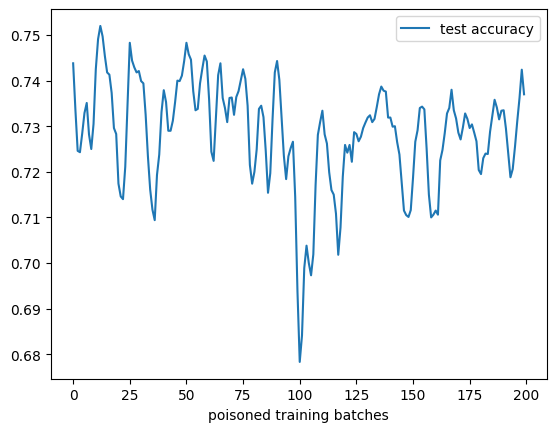

In [21]:
#plt.plot([m.accuracy for m in metrics], label="train accuracy")
plt.plot([m.accuracy for m in tmetrics], label="test accuracy")
plt.legend()
plt.xlabel("poisoned training batches")

In [22]:
attack_success_rate = train.accuracy_from_params(pstate.params, fully_poisoned)
clean_test_acc = train.accuracy_from_params(state.params, cifar10_test)
pois_test_acc = train.accuracy_from_params(pstate.params, cifar10_test)

Test accuracy (clean) 0.7468
Test accuracy (backdoored) 0.737
Attack success rate: 0.9007778
Absolute diff: 13.824802801012993
Relative diff: 0.145316079229549


Text(0.5, 0, 'Layers')

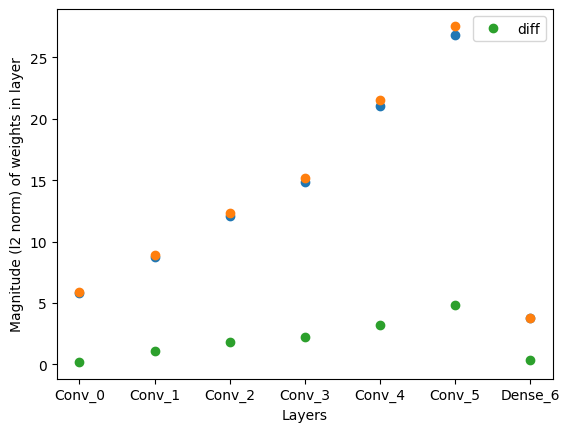

In [23]:
diff = jax.tree_map(lambda x, y: x - y, state.params, pstate.params)

magnitude = {
    k: np.linalg.norm(v["kernel"]) for k, v in state.params.items()
}

pmagnitude = {
    k: np.linalg.norm(v["kernel"]) for k, v in pstate.params.items()
}

dmagnitude = {
    k: np.linalg.norm(v["kernel"]) for k, v in diff.items()
}

print("Test accuracy (clean)", clean_test_acc)
print("Test accuracy (backdoored)", pois_test_acc)
print("Attack success rate:", attack_success_rate)
print("Absolute diff:", sum(dmagnitude.values()))
print("Relative diff:", sum(dmagnitude.values()) / sum(pmagnitude.values()))



plt.plot(magnitude.keys(), magnitude.values(), "o")
plt.plot(pmagnitude.keys(), pmagnitude.values(), "o")
plt.plot(dmagnitude.keys(), dmagnitude.values(), "o", label="diff")
plt.legend()
plt.ylabel("Magnitude (l2 norm) of weights in layer")
plt.xlabel("Layers")

Text(0.5, 0, 'poisoned training batches')

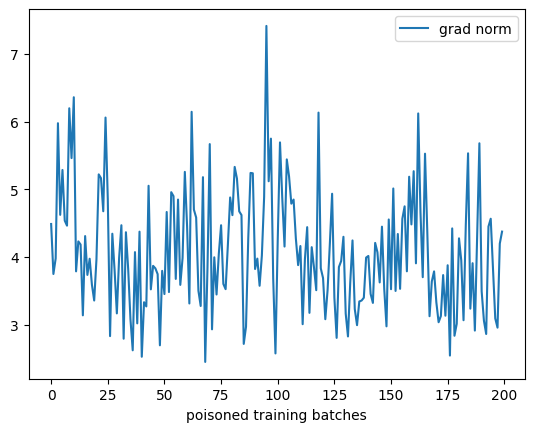

In [24]:
plt.plot([m.grad_norm for m in metrics], label="grad norm")
plt.legend()
plt.xlabel("poisoned training batches")

In [15]:
raise

RuntimeError: No active exception to reraise

In [ ]:
def convert_params_dict(params):
    new = {}
    i = 0
    for k, v in params.items():
        if "Conv" in k:
            for kk, vv in v.items():
                new[f"C{i}"] = vv
                i += 1
        else:
            new["D"] = v
    return new

In [ ]:

old_checkpoint_dir = os.path.join(module_path, "old-arch-checkpoints")
backdoored_dir = Path(old_checkpoint_dir) / "simple_pattern"
clean_dir = Path(old_checkpoint_dir) / "clean"

idx = 1
bparams, cparams, info = load_pair_of_models(idx, backdoored_dir, clean_dir)
bparams, cparams = convert_params_dict(bparams), convert_params_dict(cparams)
diff = jax.tree_map(lambda x, y: x - y, bparams, cparams)
diff_proportion = jax.tree_map(lambda x, y: np.linalg.norm(x) / np.linalg.norm(y), diff, cparams)

In [ ]:
cparams.keys()

dict_keys(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'D'])

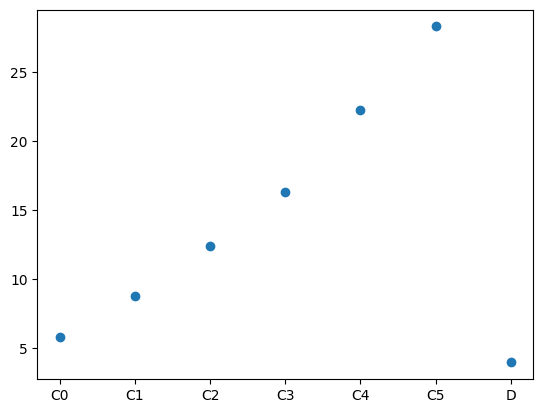

In [ ]:
magnitude = {
    k: np.linalg.norm(v["kernel"]) for k, v in cparams.items()
}

plt.plot(magnitude.keys(), magnitude.values(), "o")

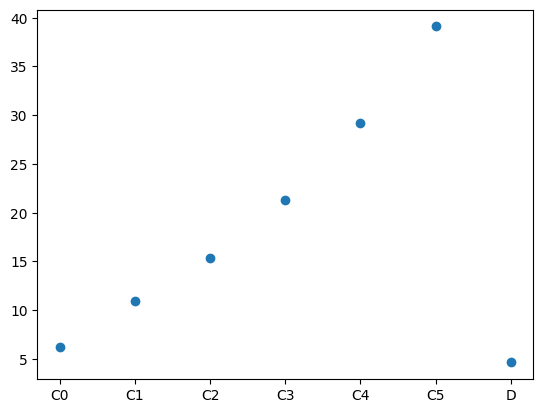

In [ ]:
magnitude = {
    k: np.linalg.norm(v["kernel"]) for k, v in bparams.items()
}

plt.plot(magnitude.keys(), magnitude.values(), "o")

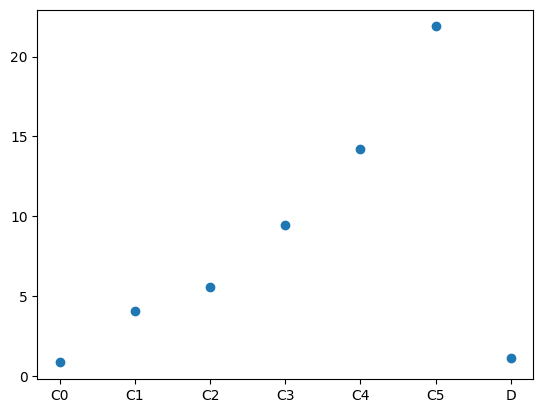

In [ ]:
magnitude = {
    k: np.linalg.norm(v["kernel"]) for k, v in diff.items()
}

plt.plot(magnitude.keys(), magnitude.values(), "o")

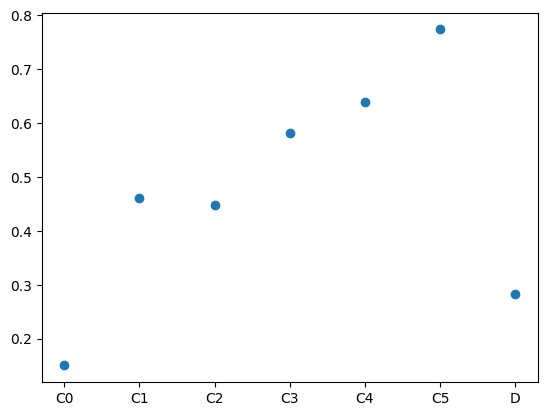

In [ ]:
magnitude = {
    k: v["kernel"] for k, v in diff_proportion.items()
}

plt.plot(magnitude.keys(), magnitude.values(), "o")

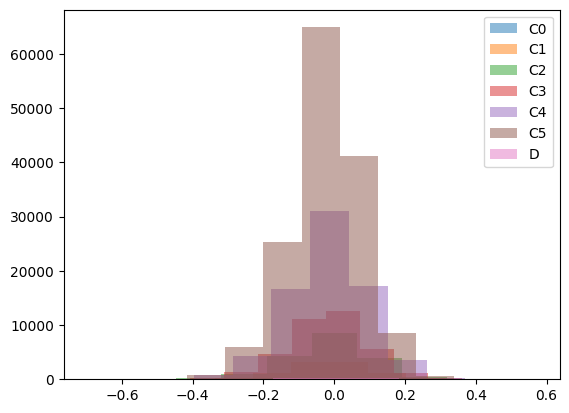

In [ ]:
for k, layer in bparams.items():
    plt.hist(layer["kernel"].flatten(), label=k, alpha=0.5)
plt.legend()